# 04 Custom Datasets With PyTorch

"I have my own dataset and I want to predict things on my own data"

### PyTorch Domain Libraries

* TorchVision
  * Is this a photo of...
* TorchAudio
  * What song is this...
* TorchText
  * Is this email positive or ...
* TorchRec [Rec = reccomendation]
  * How do we recommend similar products...
* TorchData
  * Working with datasets, made of helper functions

 ![image.png](attachment:image.png)

 ![image-2.png](attachment:image-2.png)

 ![image-3.png](attachment:image-3.png)

# Get Data

Food 101 is a large toy dataset with 101 food categories and 101000 images of food.
This has 250 manually reviewed images and 750 training images
Some images have noise or bad colors, some will be mislabeled

We are make this smaller by only looking at 3 categories and 10% of the data

We will just look at the smaller subset of data for the class, but we can scale up to the full size and run this against our GPUs etc...

Small experiment = fast experiment



In [30]:
import torch
from torch import nn
import requests
import zipfile
from pathlib import Path
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

print(torch.__version__)
print(*torch.__config__.show().split("\n"), sep="\n")

# Set the device type and device ID
device_type = "xpu" if torch.xpu.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device_id = 1  # Change this to the desired device index, e.g., 0 or 1

# Combine device type and device ID to create the device variable
device = torch.device(f"{device_type}:{device_id}" if device_type else "cpu")
print(f"You are using: {device} id {device_id}")
# print what type of device you are using using device_id
print(torch.cuda.get_device_name(device_id))

# Set random seed for reproducibility
RANDOM_SEED = 42

# Set the image batch size
BATCH_SIZE = 1

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesnt exist, download it and prepare it
if image_path.is_dir():
    print(f"{image_path} directory exists")
else:
    print(f"{image_path} directory does not exist, downloading and extracting files...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print("Downloading data...")
    f.write(request.content)
    print("Download complete")

# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping data...")
    zip_ref.extractall(image_path)
    print("Data unzipped")


2.5.1+cu124
PyTorch built with:
  - C++ Version: 201703
  - MSVC 192930154
  - Intel(R) oneAPI Math Kernel Library Version 2024.2.2-Product Build 20240823 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.5.3 (Git Hash 66f0cb9eb66affd2da3bf5f8d897376f04aae6af)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 12.4
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90
  - CuDNN 90.1
  - Magma 2.5.4
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=12.4, CUDNN_VERSION=9.1.0, CXX_COMPILER=C:/actions-runner/_work/pytorch/pytorch/builder/windows/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EHsc /Zc:__cplusplus /bigobj /FS /ut

# 2. Becoming one with the data (data prep and exploration)

Typical dataset format

* Dataset Folder
  * Training Images Folder
    * Training Images Class 1 Folder
      * Images ...
    * Training Images Class ... Folder
      * Images ...
    * Training Images Class 50 Folder
      * Images ...
  * Testing Images Folder
    * Testing Images Class 1 Folder
      * Images ...
    * Testing Images Class ... Folder
      * Images ...
    * Testing Images Class 50 Folder
      * Images ...

There are standardized ways to sort data, this is listed in the Docs/Dataset documentation of pytorch


In [31]:
def walk_through_dir(dir_path):
    """Walks through dir_path returning the contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


# Taking a break, looking at 2025 test cards

All cards must have nickel plating

* ASUS Radeon RX 6600 XT STRIX OC
  * Unknown Power Limit
* XFX Radeon RX 6600 XT Speedster Merc 308
  * Unknown Power Limit
* Sparkle ROC OC Arc A770 16 GB
  * 253w Limit
* ASRock Challenger SE OC Arc A770 16 GB
  * Looks like full nickel cooler, not 100% unknown territory
  * Updated cooler, possibly the same one used for upcoming Battlemage Challenger cards
* MSI GeForce RTX 2080 Super Gaming X Trio
  * Full nickel
  * Super high power limits 285w
* ASUS ROG-STRIX-RTX2070S-A8G-GAMING RTX 2070 Super
  * Full nickel
  * Super high power limits 319w

In [32]:
# Setup training and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir
# Class name is the folder name
# torch vision dataset documentation website: https://pytorch.org/vision/stable/datasets.html


(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### Visualizing an Image

Write code to:
1. Get all the image paths
2. Pick a random image path using `random.choice()`
3. Get image class name using `pathlib.Path.parent.stem`
4. Open the image with Python image lib, Pillow, or PIL
5. Get metadata about image and show the image



In [33]:
# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image height: {img.height}")
print(f"Random image width: {img.width}")
#img



Random image height: 408
Random image width: 512


### Visualize image with matplotlib

(-0.5, 511.5, 407.5, -0.5)

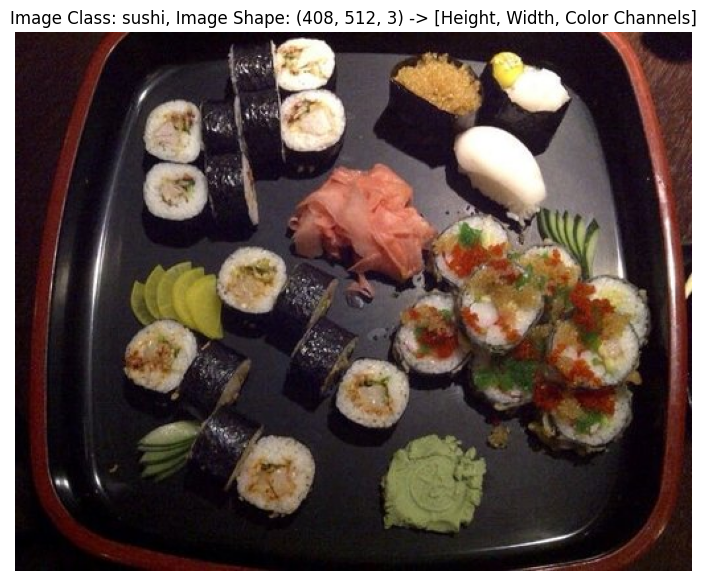

In [34]:
# Turn the image into a numpy array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class}, Image Shape: {img_as_array.shape} -> [Height, Width, Color Channels]")
plt.axis(False)


### Transforming Data, getting data into tensor format

Before we can use image data with pytorch:
1. Turn target data into tensors (numerical rep of images)
2. Turn it into a `torch.utils.data.Dataset`, then `torch.utils.data.DataLoader` for an iterable and batched version of the dataset
  * transform parameter: takes a PIL image and returns a modified/transformed version


### Transforming Data with torchvision.transforms

Transforms help you get your images ready to be used with model and perform data augmentation

In [35]:
# Write a transform for an image
data_transform = transforms.Compose([
    # Resize the image to 64 x 64
    transforms.Resize((64, 64)),
    # Flip the images randomly to increase data diversity, 50% will be flipped horizontally
    transforms.RandomHorizontalFlip(p = 0.5),
    # Turn the image into a PyTorch tensor
    transforms.ToTensor()
])

In [36]:
data_transform(img).shape, data_transform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

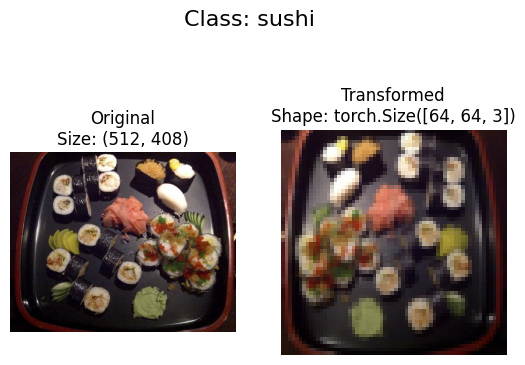

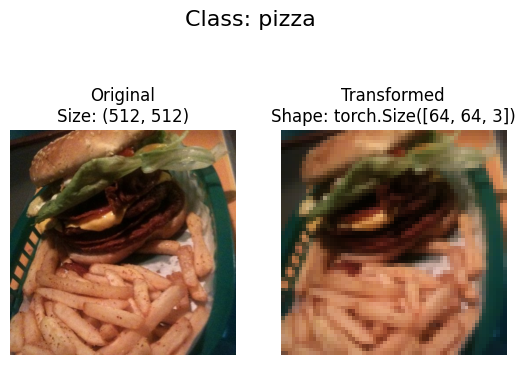

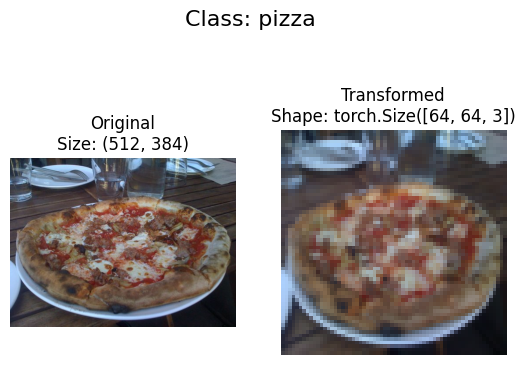

In [37]:
def plot_transformed_images(image_paths: list, transform, n = 3, seed = None):
    """
    Selects images from a path of images and loads/transforms them, plots the original and transformed images.
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k = n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
                        fig, ax = plt.subplots(nrows = 1, ncols = 2)
                        ax[0].imshow(f)
                        ax[0].set_title(f"Original\nSize: {f.size}")
                        ax[0].axis(False)

                        # Transforma nd plot target image
                        transformed_image = transform(f).permute(1, 2, 0)
                        ax[1].imshow(transformed_image)
                        ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
                        ax[1].axis(False)

                        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)
plot_transformed_images(image_paths = image_path_list, transform = data_transform, seed = RANDOM_SEED)

### Option 1 Loading image data using `ImageFolder`

Load our custom data into tensors

`torchvision.datasets.ImageFolder`

In [38]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = data_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [39]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [40]:
# Get class names as a list
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [41]:
# Check the len of the datasets
len(train_data), len(test_data)

(225, 75)

In [42]:
# Look at the first data sample
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [43]:
# Index on train_data Dataset to get a single image and label

img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")


Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64])
Permuted shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

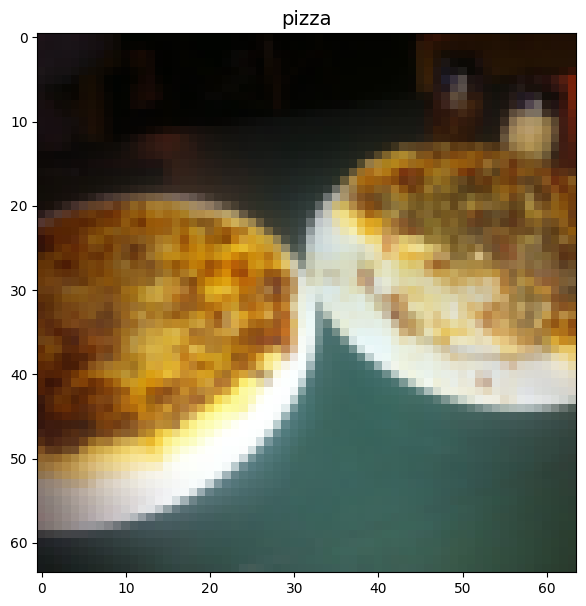

In [44]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out the different shapes
print(f"Original shape: {img.shape}")
print(f"Permuted shape: {img_permute.shape}")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis
plt.title(class_names[label], fontsize = 14)

### Turn loading images into `DataLoader`'s

A `DataLoader` is going to help us turn out `Dataset` into iterables so we can use `batch_size`

In [45]:
# Turn train and test datasets into DataLoaders


train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, num_workers=4, shuffle = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, num_workers=4, shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1f590875160>,
 <torch.utils.data.dataloader.DataLoader at 0x1f5905e8590>)

In [46]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [47]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> Batch size, Color channels, Height, Width")
print(f"Label shape: {label.shape} -> Batch size")

Image shape: torch.Size([1, 3, 64, 64]) -> Batch size, Color channels, Height, Width
Label shape: torch.Size([1]) -> Batch size


### Option 2 Loading Image Data With Custom Dataset

1. Load images from file
2. Get class names
3. Get classes as dictionary from dataset

* Pros
  * Can create a `Dataset` from anything
  * Not limited to pytorch pre-built `Dataset` functions
* Cons
  * Even though you could create a `Dataset` it doesnt mean it will work
  * Using a custom `Dataset` requires more code, larger failure domain



In [48]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a helper func to get class names

In [49]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create custom `Dataset` to replicate `DataLoader`

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory as well as a transform if we like to transform our data
3. Create several attributes:
   * paths - paths of our images
   * transform - the transform we'd like to use
   * classes - list of the target classes
   * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this func will open an imae
5. Overwrite the `__len()__` method to return the len of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [50]:
# Write a custom dataset class
from torch.utils.data import Dataset

# Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset): # Inherit from torch.utils.data.Dataset
    # Initialize custom dataset
    def __init__(self, targ_dir: str, transform = None):
        # Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # Create a funct to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it"
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # Override the __len__ method
    def __len__(self) -> int:
        "Returns the total number of samples"
        return len(self.paths)
    
    # Override the __getitem__ method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sampel of data, data and label"
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # Expects path in format of data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]
        # Transform if neccessary
        if self.transform:
            return self.transform(img), class_idx # Return transformed image and class index
        else:
            return img, class_idx # Return image and class index if no transform


In [51]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [52]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir = train_dir, transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir, transform = test_transforms)

In [53]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1f5937c06e0>,
 <__main__.ImageFolderCustom at 0x1f5908e4290>)

In [54]:
len(train_data), len(train_data_custom), len(test_data), len(test_data_custom)

(225, 225, 75, 75)

In [55]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [56]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [57]:
# Check for equality between original ImageFolder and ImageFolderCustomDataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


In [79]:
import torch
import time
from tqdm import tqdm

matrix_size = 3000
loops = 15
runs = 30
total_cpu_time = 0
total_gpu0_time = 0
total_gpu1_time = 0


for i in tqdm(range(runs)):

    torch.manual_seed(42)
    device_cpu = torch.device("cpu")
    A_cpu = torch.randn(matrix_size, matrix_size, device=device_cpu)
    B_cpu = torch.randn(matrix_size, matrix_size, device=device_cpu)
    start_time_cpu = time.time()
    for _ in range(loops):
        with torch.autocast(device_type="cpu", enabled=False):
            mul = torch.matmul(A_cpu, B_cpu)
    cpu_time = time.time() - start_time_cpu
    total_cpu_time += cpu_time

    torch.cuda.manual_seed(42)
    device_cuda0 = torch.device("cuda:0")
    A_cuda0 = torch.randn(matrix_size, matrix_size, device=device_cuda0)
    B_cuda0 = torch.randn(matrix_size, matrix_size, device=device_cuda0)
    start_time_cuda0 = time.time()
    for _ in range(loops):
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=True):
            mul = torch.matmul(A_cuda0, B_cuda0)
    cuda_time0 = time.time() - start_time_cuda0
    total_gpu0_time += cuda_time0

    torch.cuda.manual_seed(42)
    device_cuda1 = torch.device("cuda:1")
    A_cuda1 = torch.randn(matrix_size, matrix_size, device=device_cuda1)
    B_cuda1 = torch.randn(matrix_size, matrix_size, device=device_cuda1)
    start_time_cuda1 = time.time()
    for _ in range(loops):
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=True):
            mul = torch.matmul(A_cuda1, B_cuda1)
    cuda_time1 = time.time() - start_time_cuda1
    total_gpu1_time += cuda_time1

    pass

print(f"CPU time: {total_cpu_time:.8f}")
print(f"CUDA 4070S time: {total_gpu0_time:.8f}")
print(f"CUDA 2080 time: {total_gpu1_time:.8f}")

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]

CPU time: 19.58782053
CUDA 4070S time: 0.01677537
CUDA 2080 time: 0.01950502
